<a href="https://www.kaggle.com/code/averma111/playground-s3e12-xgboost-lgbm-catboost?scriptVersionId=124997163" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_validate, KFold, GridSearchCV
from sklearn.metrics import mean_squared_log_error
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import  CatBoostClassifier, Pool
import warnings
warnings.filterwarnings('ignore')
from IPython.display import display, HTML


In [3]:
!wget http://bit.ly/3ZLyF82 -O CSS.css -q
    
from IPython.core.display import HTML
with open('./CSS.css', 'r') as file:
    custom_css = file.read()

HTML(custom_css)

In [12]:
Root_path ='/kaggle/input/playground-series-s3e12'
Root_original ='/kaggle/input/kidney-stone-prediction-based-on-urine-analysis'

original = pd.read_csv(Root_original+'/kindey stone urine analysis.csv')
train = pd.read_csv(Root_path+'/train.csv')
test = pd.read_csv(Root_path+'/test.csv')

In [5]:
train.head(5)

,id,gravity,ph,osmo,cond,urea,calc,target
0,0,1.013,6.19,443,14.8,124,1.45,0
1,1,1.025,5.40,703,23.6,394,4.18,0
2,2,1.009,6.13,371,24.5,159,9.04,0
3,3,1.021,4.91,442,20.8,398,6.63,1
4,4,1.021,5.53,874,17.8,385,2.21,1


In [6]:
test.head(5)

,id,gravity,ph,osmo,cond,urea,calc
0,414,1.017,5.24,345,11.5,152,1.16
1,415,1.020,5.68,874,29.0,385,3.46
2,416,1.024,5.36,698,19.5,354,13.00
3,417,1.020,5.33,668,25.3,252,3.46
4,418,1.011,5.87,567,29.0,457,2.36


In [18]:
def summary(text, df):
    print(f'{text} shape: {df.shape}')
    summ = pd.DataFrame(df.dtypes, columns=['dtypes'])
    summ['null'] = df.isnull().sum()
    summ['unique'] = df.nunique()
    summ['min'] = df.min()
    summ['median'] = df.median()
    summ['max'] = df.max()
    summ['mean'] = df.mean()
    summ['std'] = df.std()
    return summ


In [20]:
summary('test',test)

test shape: (276, 7)


,dtypes,null,unique,min,median,max,mean,std
id,int64,0,276,414.000,551.500,689.000,551.500000,79.818544
gravity,float64,0,27,1.005,1.019,1.034,1.018330,0.006569
ph,float64,0,62,4.900,5.730,7.940,5.939312,0.607143
osmo,int64,0,75,187.000,658.000,1236.000,654.891304,236.361932
cond,float64,0,58,5.100,23.600,38.000,21.886594,7.346069
urea,int64,0,71,64.000,282.000,620.000,280.985507,134.877856
calc,float64,0,74,0.170,3.230,14.340,4.076848,3.088524


In [22]:
df_full = pd.concat([train, original])
for col in original.columns:
    df_full[col] = df_full[col].astype('float64')

In [23]:
summary('full',df_full)

full shape: (493, 8)


,dtypes,null,unique,min,median,max,mean,std
id,float64,79,414,0.000,206.500,413.00,206.500000,119.655756
gravity,float64,0,29,1.005,1.018,1.04,1.017929,0.006761
ph,float64,0,75,4.760,5.770,7.94,5.967160,0.655861
osmo,float64,0,80,187.000,668.000,1236.00,645.344828,235.320087
cond,float64,0,67,5.100,21.900,38.00,21.337931,7.579484
urea,float64,0,74,10.000,272.000,620.00,276.693712,135.568157
calc,float64,0,86,0.170,3.160,14.34,4.118540,3.221149
target,float64,0,2,0.000,0.000,1.00,0.442191,0.497151


In [26]:
print(f' Row => {df_full.shape[0]}, Columns => {df_full.shape[1]}')

 Row => 493, Columns => 8


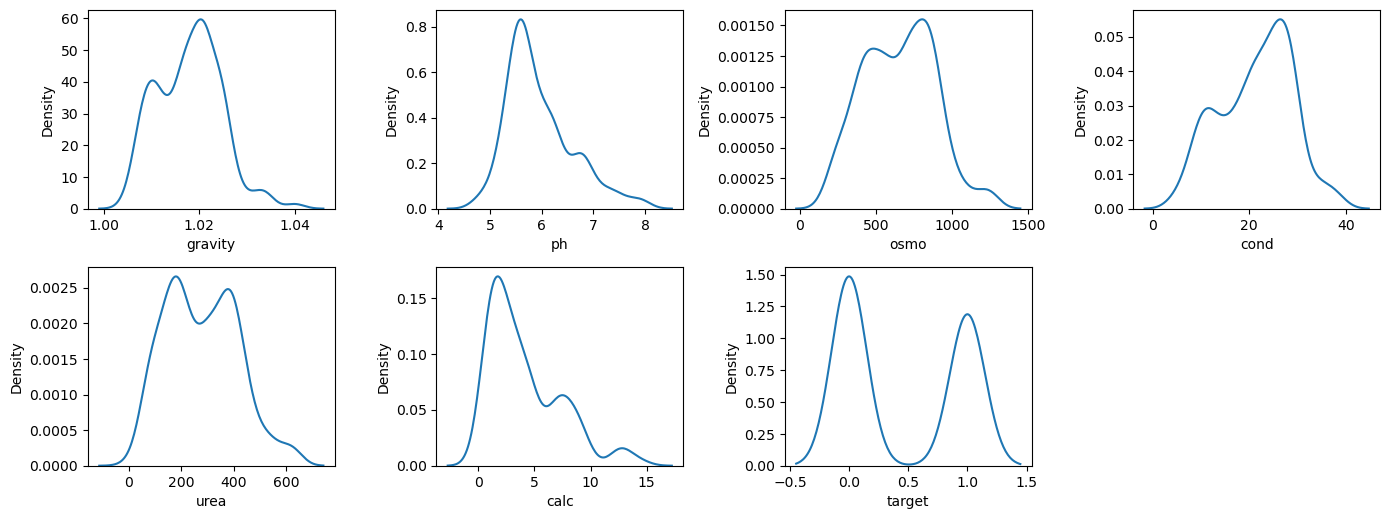

In [28]:
plt.figure(figsize=(14,10))
for i in range(1, len(df_full.columns)):
    plt.subplot(4,4,i)
    sns.kdeplot(x=train[train.columns[i]], label='Full Dataset')
    plt.tight_layout()

<AxesSubplot:>

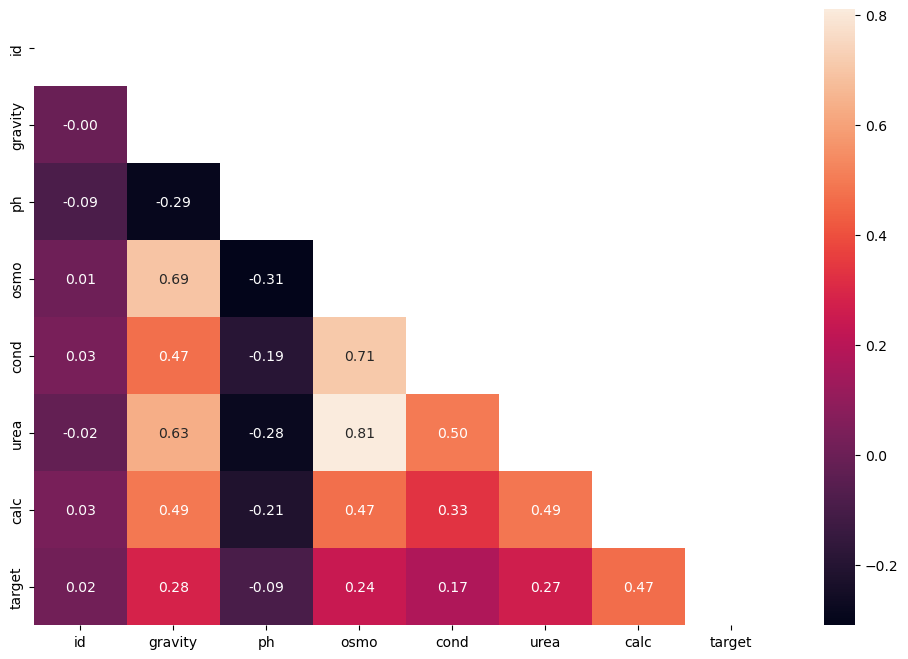

In [30]:
plt.figure(figsize=(12,8))
mask = np.triu(np.ones_like(df_full.corr()))
sns.heatmap(train.corr(), mask=mask, annot=True, fmt='.2f')

In [32]:
df_full.columns

Index(['id', 'gravity', 'ph', 'osmo', 'cond', 'urea', 'calc', 'target'], dtype='object')

In [34]:
features = ['gravity',
            'ph', 
            'osmo', 
            'cond',
            'urea', 
            'calc']

In [35]:
X = df_full[features].copy()
y = df_full['target'].copy()

In [36]:
X_train, X_val, y_train, y_val = train_test_split(X,y,test_size=0.2, random_state=52)

In [53]:
model_dict = {
    'Light GBM': LGBMClassifier(),
    'XG Boost' : XGBClassifier(),
    'Cat Boost' : CatBoostClassifier()
}

In [54]:
def evaluation(model_str, y_pred, y_pred_train):
    results = {
        'model': model_str,
        'rmsleval': mean_squared_log_error(y_val, y_pred, squared=True),
        'rmsle_train': mean_squared_log_error(y_train, y_pred_train, squared=True)
    }
    return results

In [56]:
result_list = []
for model in model_dict:
    model_dict[model].fit(X_train, y_train,verbose=True)
    y_pred = model_dict[model].predict(X_val)
    y_pred_train = model_dict[model].predict(X_train)
    result = evaluation(model, y_pred, y_pred_train)
    result_list.append(result)
df_eval = pd.DataFrame(result_list)
df_eval

Learning rate set to 0.006922
0:	learn: 0.6904713	total: 846us	remaining: 846ms
1:	learn: 0.6874771	total: 1.51ms	remaining: 756ms
2:	learn: 0.6850308	total: 2.22ms	remaining: 737ms
3:	learn: 0.6825314	total: 2.94ms	remaining: 731ms
4:	learn: 0.6797638	total: 3.55ms	remaining: 707ms
5:	learn: 0.6771521	total: 4.24ms	remaining: 703ms
6:	learn: 0.6747332	total: 4.88ms	remaining: 692ms
7:	learn: 0.6719011	total: 5.54ms	remaining: 687ms
8:	learn: 0.6693580	total: 6.16ms	remaining: 679ms
9:	learn: 0.6670242	total: 6.99ms	remaining: 692ms
10:	learn: 0.6649222	total: 7.72ms	remaining: 694ms
11:	learn: 0.6629196	total: 8.34ms	remaining: 687ms
12:	learn: 0.6607798	total: 8.95ms	remaining: 680ms
13:	learn: 0.6583015	total: 9.6ms	remaining: 676ms
14:	learn: 0.6563049	total: 10.2ms	remaining: 672ms
15:	learn: 0.6534845	total: 10.8ms	remaining: 667ms
16:	learn: 0.6516527	total: 11.5ms	remaining: 662ms
17:	learn: 0.6496968	total: 12.1ms	remaining: 660ms
18:	learn: 0.6475687	total: 12.7ms	remaining: 

,model,rmsleval,rmsle_train
0,Light GBM,0.126180,0.004878
1,XG Boost,0.126180,0.002439
2,Cat Boost,0.121327,0.035363


In [59]:
X_test = test[features].copy()

In [60]:
model = CatBoostClassifier()
model.fit(X, y)
cost = model.predict(X_test)

df_test = pd.DataFrame(data={'id': test['id'],
                             'target': target})
df_test.to_csv('submission.csv', index=False)
df_test

Learning rate set to 0.007617
0:	learn: 0.6902755	total: 722us	remaining: 722ms
1:	learn: 0.6875879	total: 1.36ms	remaining: 678ms
2:	learn: 0.6848491	total: 2.02ms	remaining: 670ms
3:	learn: 0.6816111	total: 2.6ms	remaining: 648ms
4:	learn: 0.6790019	total: 3.17ms	remaining: 631ms
5:	learn: 0.6766803	total: 3.73ms	remaining: 618ms
6:	learn: 0.6739624	total: 4.32ms	remaining: 613ms
7:	learn: 0.6712331	total: 4.91ms	remaining: 608ms
8:	learn: 0.6689010	total: 5.38ms	remaining: 593ms
9:	learn: 0.6667330	total: 5.93ms	remaining: 587ms
10:	learn: 0.6641913	total: 6.5ms	remaining: 585ms
11:	learn: 0.6620149	total: 7.04ms	remaining: 579ms
12:	learn: 0.6593987	total: 7.6ms	remaining: 577ms
13:	learn: 0.6563469	total: 8.14ms	remaining: 573ms
14:	learn: 0.6535857	total: 8.68ms	remaining: 570ms
15:	learn: 0.6511246	total: 9.21ms	remaining: 566ms
16:	learn: 0.6482167	total: 9.75ms	remaining: 564ms
17:	learn: 0.6463840	total: 10.3ms	remaining: 562ms
18:	learn: 0.6442097	total: 10.8ms	remaining: 56

NameError: name 'target' is not defined